Before finalizing RNA-seq criteria, I need to make sure that all required fields are there and that they are correct.

In [1]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')

# The usual suspects
import os
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('poster')

# Turn off scientific notation
np.set_printoptions(precision=5, suppress=True)

last updated: 2017-08-08 
Git hash: a2ed76a7701599bb189f432fbe96236078cf8174


In [2]:
# %load ../../bin/load.py
from pymongo import MongoClient
with open('/home/fearjm/Projects/ncbi_remap/output/.mongodb_host', 'r') as fh:
    host = fh.read().strip()
client = MongoClient(host=host, port=27022)
db = client['sra2']
remap = db['remap']

In [3]:
remap.count()

27598

In [4]:
# List of pre-aln-flags
[x['_id'] for x in remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$project': {
            '_id': 0,
            'flags': '$runs.pre_aln_flags'
        }
    },
    {'$unwind': '$flags'},
    {'$group': {'_id': '$flags'}}
])]

['quality_scores_bad',
 'download_bad',
 'SE',
 'keep_R2',
 'first_strand',
 'complete',
 'unstranded',
 'second_strand',
 'PE',
 'same_strand',
 'opposite_strand',
 'alignment_bad',
 'keep_R1',
 'abi_solid']

In [5]:
remap.find_one()

{'_id': 'SRX2581987',
 'bioproject': 'PRJNA357269',
 'contacts': [{'email': 'marcelorivas@gmail.com',
   'first_name': 'Marcelo',
   'last_name': 'Rivas'}],
 'papers': [],
 'runs': [{'avgReadLen': {'R1': 142.97425121403273, 'R2': 143.68871950516282},
   'libsize': {'R1': 17428278, 'R2': 17428278},
   'md5': {'R1': '1ef1ee5447afb2a8852f52224abf3940',
    'R2': '144600f42c19d3c2101b968d9f834567'},
   'pre_aln_flags': ['PE', 'unstranded', 'complete'],
   'pre_aln_workflow': {'bam_stat': {'non_unique': 292001,
     'nonsplice_reads': 3841210,
     'optical_pcr_duplicates': 0,
     'proper_pair_map_to_different_chrom': 0,
     'qc_failed': 0,
     'read_1': 2098571,
     'read_2': 1773091,
     'reads_map_minus': 1935259,
     'reads_map_plus': 1936403,
     'reads_mapped_proper_pairs': 3238278,
     'splice_reads': 30452,
     'total_records': 35575122,
     'unique': 3871662,
     'unmapped_reads': 30692893},
    'fastq_screen': {'adapters': {'multiple_hits_one_library_percent': 0.0},
   

In [18]:
srx = 'SRX2581987'
srr = 'SRR5278103'

fname = '../../output/prealignment/raw/{srx}/{srr}/{srr}.hisat2.bam.feature_counts.counts.summary'.format(srx=srx, srr=srr)
fname2 = '../../output/prealignment/raw/{srx}/{srr}/{srr}.hisat2.bam.feature_counts.counts.jcounts'.format(srx=srx, srr=srr)

In [9]:
from ncbi_remap.parser import parse_featureCounts_jcounts, parse_featureCounts_summary

In [ ]:
df = parse_featureCounts_summary(srr, fname)

In [19]:
df2 = parse_featureCounts_jcounts(srr, fname2)

In [20]:
df.head()

,Assigned,Unassigned_Ambiguity,Unassigned_MultiMapping,Unassigned_NoFeatures,Unassigned_Unmapped,Unassigned_MappingQuality,Unassigned_FragmentLength,Unassigned_Chimera,Unassigned_Secondary,Unassigned_Nonjunction,Unassigned_Duplicate
SRR5278103,1003825,52134,484051,1116050,15042248,0,109827,38381,0,0,0


In [21]:
df2.head()

,PrimaryGene,SecondaryGenes,Site1_chr,Site1_location,Site1_strand,Site2_chr,Site2_location,Site2_strand,count
sample,,,,,,,,,
SRR5278103,NaN,NaN,chrUn_CP007073v1,6601,NaN,chrUn_CP007073v1,9493,NaN,1
SRR5278103,NaN,NaN,chrUn_CP007074v1,26454,NaN,chrUn_CP007074v1,46418,NaN,1
SRR5278103,NaN,NaN,chrUn_CP007075v1,3082,NaN,chrUn_CP007075v1,4335,NaN,170
SRR5278103,NaN,NaN,chrUn_CP007075v1,3082,NaN,chrUn_CP007075v1,6741,NaN,127
SRR5278103,NaN,NaN,chrUn_CP007075v1,4393,NaN,chrUn_CP007075v1,6734,NaN,12


In [30]:
mask = ~(df2.PrimaryGene.isnull())

In [31]:
df2.loc[mask, 'count'].sum()

15039

In [39]:
dd = pd.DataFrame(list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.pre_aln_workflow.featurecounts.Assigned_Junction': {'$exists': 1}
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$_id',
            'jcount': '$runs.pre_aln_workflow.featurecounts.Assigned_Junction'
        }
    }
])))

In [41]:
import seaborn as sns

In [43]:
dd.set_index('srx', inplace=True)

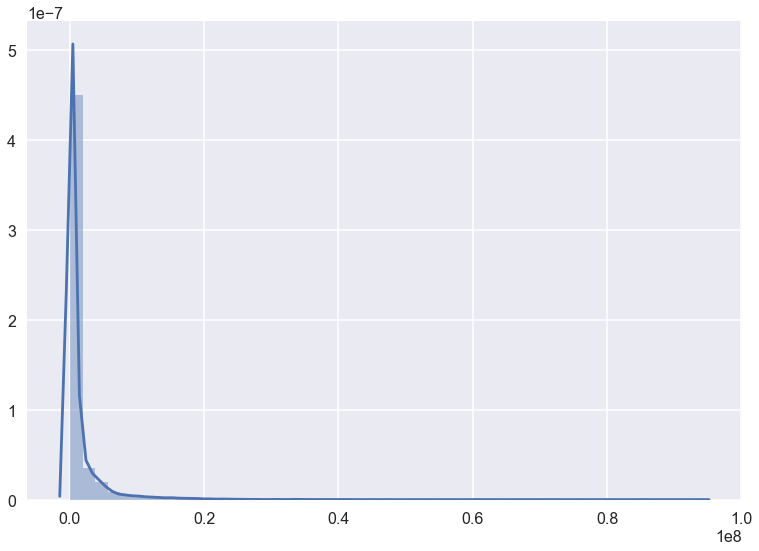

In [44]:
sns.distplot(dd)

In [47]:
srx = 'SRX2581987'
srr = 'SRR5278103'

summary = '../../output/prealignment/raw/{srx}/{srr}/{srr}.hisat2.bam.feature_counts.counts.summary'.format(srx=srx, srr=srr)
jcount = '../../output/prealignment/raw/{srx}/{srr}/{srr}.hisat2.bam.feature_counts.counts.jcounts'.format(srx=srx, srr=srr)

In [48]:
dfJ = parse_featureCounts_jcounts(srr, jcount)

In [51]:
if dfJ.shape[0] > 0:
    num_junction_reads = dfJ.loc[~dfJ.PrimaryGene.isnull(), 'count'].sum()
else:
    num_junction_reads = 0

In [53]:
dfS = parse_featureCounts_summary(srr, summary)

In [54]:
dd = dfS.to_dict('index')[srr]

In [56]:
dd['Assigned_Junction'] = num_junction_reads

In [57]:
dd

{'Assigned': 1003825,
 'Assigned_Junction': 15039,
 'Unassigned_Ambiguity': 52134,
 'Unassigned_Chimera': 38381,
 'Unassigned_Duplicate': 0,
 'Unassigned_FragmentLength': 109827,
 'Unassigned_MappingQuality': 0,
 'Unassigned_MultiMapping': 484051,
 'Unassigned_NoFeatures': 1116050,
 'Unassigned_Nonjunction': 0,
 'Unassigned_Secondary': 0,
 'Unassigned_Unmapped': 15042248}

In [58]:
def clean_types(dic):
    newDic = {}
    for k, v in dic.items():
        if isinstance(v, np.int64):
            newDic[k] = int(v)
        elif isinstance(v, np.float64):
            newDic[k] = float(v)
        elif v is np.nan:
            pass
        elif v is None:
            pass
        else:
            newDic[k] = v
    return newDic

In [59]:
clean_types(dd)

{'Assigned': 1003825,
 'Assigned_Junction': 15039,
 'Unassigned_Ambiguity': 52134,
 'Unassigned_Chimera': 38381,
 'Unassigned_Duplicate': 0,
 'Unassigned_FragmentLength': 109827,
 'Unassigned_MappingQuality': 0,
 'Unassigned_MultiMapping': 484051,
 'Unassigned_NoFeatures': 1116050,
 'Unassigned_Nonjunction': 0,
 'Unassigned_Secondary': 0,
 'Unassigned_Unmapped': 15042248}

In [67]:
curr_feature = remap.find_one({'runs.srr': srr}, {'_id': 0, 'runs.pre_aln_workflow.featurecounts': 1})
curr_feature

{'runs': [{'pre_aln_workflow': {'featurecounts': {'Assigned_Junction': 15039,
     'PrimaryGene': 'Unassigned_Duplicate',
     'SecondaryGenes': 0,
     'Site1_chr': nan,
     'Site1_location': nan,
     'Site1_strand': nan,
     'Site2_chr': nan,
     'Site2_location': nan,
     'Site2_strand': nan,
     'count': nan}}}]}

In [68]:
remap.update_one({'runs.srr': srr}, {'$set': {'runs.$.pre_aln_workflow.featurecounts': clean_types(dd)}})

In [69]:
up_feature = remap.find_one({'runs.srr': srr}, {'_id': 0, 'runs.pre_aln_workflow.featurecounts': 1})
up_feature

{'runs': [{'pre_aln_workflow': {'featurecounts': {'Assigned': 1003825,
     'Assigned_Junction': 15039,
     'Unassigned_Ambiguity': 52134,
     'Unassigned_Chimera': 38381,
     'Unassigned_Duplicate': 0,
     'Unassigned_FragmentLength': 109827,
     'Unassigned_MappingQuality': 0,
     'Unassigned_MultiMapping': 484051,
     'Unassigned_NoFeatures': 1116050,
     'Unassigned_Nonjunction': 0,
     'Unassigned_Secondary': 0,
     'Unassigned_Unmapped': 15042248}}}]}